## Project- AirFares
--- -------------------

### A. Introduction
--- -------------------

This project studies the german domestic airfares during the period 25-10-2019 to 24-04-2020 between major airports in Germany. The aim of the project is to apply the techniques of machine learning on the dataset and understand the trends in pricing with respect to the various features such the booking date, departure & arrival cities, departure time etc. 
#### B. Details of dataset:
-- -------------------
1. Source: [https://www.kaggle.com/datasets/darjand/domestic-german-air-fares](https://www.kaggle.com/datasets/darjand/domestic-german-air-fares)
2. Generation mode: web scraping
3. Time period considered: 25-10-2019 to 24-04-2020 (6 months).
4. Total entries: 63,000
5. Features:
    * departure_city: The city from which the flight departs.
    * arrival_city: The city to which the flight arrives.
    * scrape_date: The date when flight price information was retrieved.
    * departure_date: The departure date of the flight (25-10-2019 to 24-04-2020).
    * departure_date_distance: How far in advance (e.g., "1 week") the flight was booked.
    * departure_time: The departure time of the flight.
    * arrival_time: The arrival time of the flight.
    * airline: The airline that operates the flight.
    * stops: The number of layovers or stops during the flight.
    * price (€): The price of the flight ticket in Euros.

#### C. Imports:
-- ----------

In [529]:
#imports
import numpy as np
import pandas as pd
import sklearn.model_selection as ms
import sklearn.feature_extraction.text as text
import sklearn.naive_bayes as nb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, r2_score, mean_squared_error
from sklearn.decomposition import PCA
from datetime import datetime
import holidays
import time
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf


pd.set_option('display.max_rows', 20)


#### D. Load the dataset:
-- ------------------

In [530]:
#Load the data set
df = pd.read_csv('./data/German Air Fares.csv');

#### E. Data Understanding:
-- ----------------------

##### E.1 Basic statistics:

In [531]:
#Basic statistics
df.shape;                                           #--> (62626, 10)
df.info();df.isna().sum();                          #--> (No null objects)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62626 entries, 0 to 62625
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   departure_city           62626 non-null  object
 1   arrival_city             62626 non-null  object
 2   scrape_date              62626 non-null  object
 3   departure_date           62626 non-null  object
 4   departure_date_distance  62626 non-null  object
 5   departure_time           62626 non-null  object
 6   arrival_time             62626 non-null  object
 7   airline                  62626 non-null  object
 8   stops                    62626 non-null  object
 9   price (€)                62626 non-null  object
dtypes: object(10)
memory usage: 4.8+ MB


##### E.2 Understanding departure and arrival cities
-- ----------------------

In [532]:
df.departure_city.unique();
# a. Extract departure city name, discard shortform (e.g. DUS Düsseldorf -> Düsseldorf)
df['departure_city'] = df['departure_city'].astype(str).apply(lambda x: x.split()[1] if ' ' in x else x)

df.arrival_city.unique();
# b. Extract arrival city name, discard shortform (e.g. DUS Düsseldorf -> Düsseldorf)
df['arrival_city'] = df['arrival_city'].astype(str).apply(lambda x: x.split()[1] if ' ' in x else x)

# c. Replace departure & arrival cities with their respective rankings
airport_ranking = pd.read_csv("./data/German Airport Ranking.csv")
airport_ranking_dict = dict(
    zip(airport_ranking['Airport'], airport_ranking['Rank']))

df['departure_city'] = df['departure_city'].map(airport_ranking_dict)
df['arrival_city'] = df['arrival_city'].map(airport_ranking_dict)

##### E.2 Conclusion: 
* **ToDos:**
    * *A histogram showing distribution of departure and arrival cities would be interesting.*</font>

##### E.3 Understanding departure and scrape dates
-- ----------------------

In [533]:
# a. Departure dates: Find the departure date frequencies: How spread are they?
dep_dates = pd.to_datetime(df['departure_date'], dayfirst=True);
dep_dates = sorted(dep_dates.unique()); 
dep_dates = pd.Series(dep_dates);
dep_dates.shape;                                    
dep_dates.diff(periods=1).unique();        

# b. Scrape dates: Find the scrape date frequencies: How spread are they?
scrape_dates = pd.to_datetime(df['scrape_date'], dayfirst=True);
scrape_dates = sorted(scrape_dates.unique()); 
scrape_dates = pd.Series(scrape_dates);
scrape_dates.shape;                                    
scrape_dates.diff(periods=1).unique();
# -------------------------------------------------------
# c. Convert all date data into date-time format
df.departure_date = pd.to_datetime(df.departure_date, dayfirst=True);
df.scrape_date = pd.to_datetime(df.scrape_date, dayfirst=True);

# c. Sort the dataframe according to departure dates
df.sort_values(by='departure_date', inplace = True)
#print('Dataframe sorted according to departure date: ',df.departure_date.is_monotonic_increasing); #-> True

#--> Additionally, it was verified that there are no illegal date values.

##### E3: Conclusion: 
* **Departure dates:**
    * 42 unique departure dates
    * departure date frequencies are not unique -> ['1 days', '11 days', '5 days', '44 days', '85 days']
* **Scrape dates:**
    * scrape date frequencies are only from 18-24.10.2019
    * scrape date frequencies are unique -> 1 day

##### E.4 Understanding departure_date_distance
-- ----------------------

In [534]:
df.departure_date_distance.value_counts();           
#--> 
# 6 months    12672
# 6 weeks     11222
# 1 month     10092
# 1 week       9949
# 3 month      9748
# 2 weeks      7850
# 2 week       1093

# Replace vague departure_date_distance (weeks, months etc.) with differences as days 
df.departure_date_distance =  (df['departure_date'] - df['scrape_date']).dt.days

##### E.5 Understanding departure and arrival times
-- ----------------------

In [535]:
# a. Uniformize time formats ('Uhr', am/pm) into xx:xx 24-hour format
def convert_to_24_hour_format(time_str):
    if 'Uhr' in time_str:
        return datetime.strptime(time_str, '%H:%M Uhr').strftime('%H:%M')
    else:
        return datetime.strptime(time_str, '%I:%M%p').strftime('%H:%M')

# Convert departure time column to 24-hour format
df['departure_time'] = df['departure_time'].apply(convert_to_24_hour_format)
df['arrival_time'] = df['arrival_time'].apply(convert_to_24_hour_format)

# Strip only the hour (to make matters simple)
df['departure_time_hour'] = df['departure_time'].apply(lambda x: int(x.split(':')[0]))

##### E.6 Understanding Airlines
-- ---------------------------------------------

In [536]:
# a. Drop rows with 'Mehrere Fluglinien' and 'Multiple airlines'

df = df[~df['airline'].isin(['Mehrere Fluglinien', 'Multiple Airlines'])]
df['airline'] = df['airline'].replace('easyJet', 'EasyJet')

# b. Convert airlines into their respective ranks (numerical representation)
airport_ranking = pd.read_csv("./data/Airline Ranking.csv")
Airline_ranking_dict = dict(
    zip(airport_ranking['airline'], airport_ranking['rank']))

df['airline'] = df['airline'].map(Airline_ranking_dict)

##### E.6 Conclusion:
* **Airlines:**
    * There were 69 'Mehrere Fluglinien' and 153 'Multiple Airlines', these entries were removed.    

##### E.7 Understanding stops
---------------------------------------------

In [537]:
# Stops are converted into numerical values
# 0, 1 and 2 stops.
def countStops(stop):
    if 'direct' in stop:
        return 0
    elif '1' in stop:
        return 1
    elif '2' in stop:
        return 2
    
df['stops'] = df['stops'].apply(countStops)

##### E8. Understanding prices
--------------------------


In [538]:
# a. Rename 'price (€)' to 'price'
df = df.rename(columns={'price (€)': 'price'});

# b. format into int properly
df['price'] = df['price'].str.replace(',', '').astype(int)

##### E.8 Conclusion:
* prices are, of course, the target value

### F. New Features:
-- -----------

##### F.1: Departure weekdays

In [539]:
#  week starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6. 
if 'departure_weekday' not in df.columns:
    df.insert(5,'departure_weekday', df.departure_date.dt.weekday)

##### F.2: days_until_a_holiday

In [540]:
# Create a holidays list for Germany for the years 2019 & 2020.
# Only the national holidays as provided by the holidays library are taken into account. They are:
# date	holiday
# 0	    2019-01-01	Neujahr
# 1	    2019-04-19	Karfreitag
# 2	    2019-04-22	Ostermontag
# 3	    2019-05-01	Erster Mai
# 4	    2019-05-30	Christi Himmelfahrt
# 5	    2019-06-10	Pfingstmontag
# 6	    2019-10-03	Tag der Deutschen Einheit
# 7	    2019-12-25	Erster Weihnachtstag
# 8	    2019-12-26	Zweiter Weihnachtstag
#----------------------------------------
# 9	    2020-01-01	Neujahr
# 10	2020-04-10	Karfreitag
# 11	2020-04-13	Ostermontag
# 12	2020-05-01	Erster Mai
# 13	2020-05-21	Christi Himmelfahrt
# 14	2020-06-01	Pfingstmontag
# 15	2020-10-03	Tag der Deutschen Einheit
# 16	2020-12-25	Erster Weihnachtstag
# 17	2020-12-26	Zweiter Weihnachtstag

holiday_list = list(holidays.Germany(years=[2019, 2020]).items())

holidays_df = pd.DataFrame(holiday_list, columns=['date','holiday'])
holidays_df.date = pd.to_datetime(holidays_df.date)

# Sort holidays_df by date
holidays_df = holidays_df.sort_values(by='date')

# Define a function to find the next holiday
def find_next_holiday(departure_date):
    return holidays_df[holidays_df['date'] >= departure_date].iloc[0]['date']

# Apply the function to get the 'next_holiday'
df['next_holiday'] = df['departure_date'].apply(find_next_holiday)

# Calculate the difference between the two dates to get the 'days_until_holiday'
df['days_until_holiday'] = (df['next_holiday'] - df['departure_date']).dt.days

##### F.3: travel_time

In [541]:
# Calculate the difference between departure and arrival times in hours
df['travel_time'] = (pd.to_datetime(df['arrival_time'], format='%H:%M') - pd.to_datetime(df['departure_time'], format='%H:%M')).dt.total_seconds() / 3600

# If travel time is negative, add 24 hours
df['travel_time'] = df['travel_time'].apply(lambda x: x + 24 if x < 0 else x)

# Normalize the travel time
df['travel_time'] =  df['travel_time'].apply(lambda x: round(x, 2))


### G. Features + Y Dataframe:
-- -----------

In [542]:
df = df.drop(['scrape_date', 'departure_date', 'next_holiday', 'departure_time', 'arrival_time'],axis=1)
df = df[['departure_city', 'arrival_city',	'departure_date_distance',	'departure_weekday', 'departure_time_hour', 'travel_time', 'days_until_holiday', 'airline',	'stops', 'price']]

### H. Optional: Save dataframe as excel file
-- -----------

In [543]:
# df.to_excel('./data/dataframe_airfares.xlsx', index=False)

### I. Split data into training and test data sets
-- -----------

In [544]:
# x -> Feature variables
x = df.iloc[:,0:-1]

# y -> Target variable
y = df['price'];

# selected_features = ["departure_date_distance", "departure_weekday", "departure_time_hour", "travel_time", "days_until_holiday", "airline", "stops" ]
# x_features_selected = x[selected_features]

# Split into train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

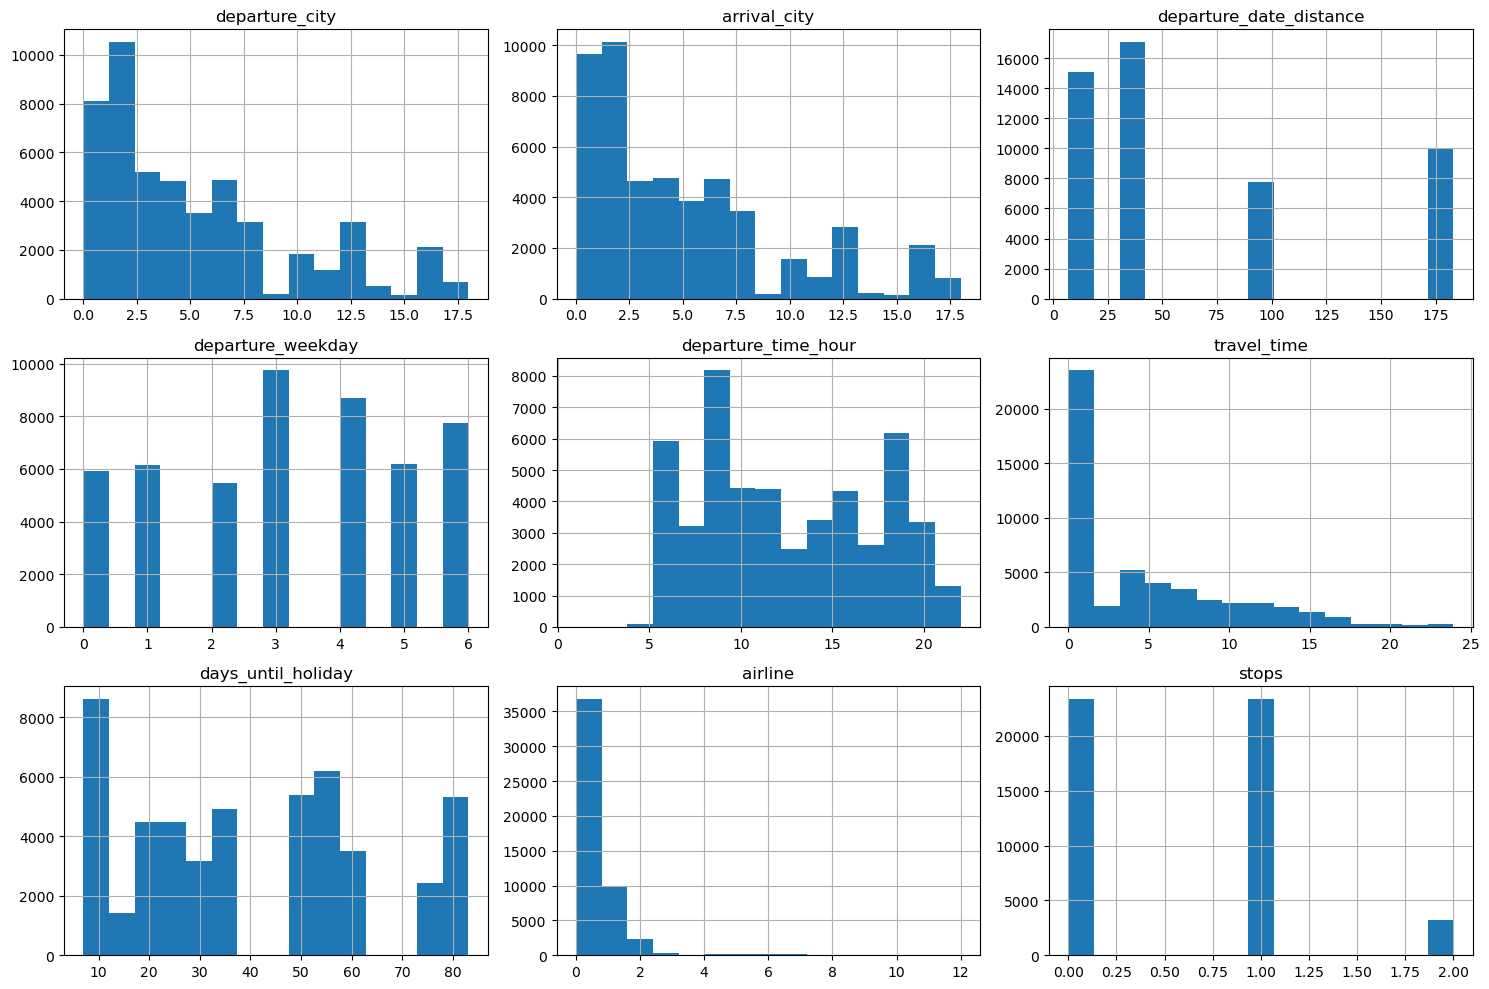

In [545]:
# Histograms of all features
x_train.hist(bins=15, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [546]:
# Statistical analysis of dependent variable.
mean_y = np.mean(y)
median_y = np.median(y)
mode_y = stats.mode(y)
std_dev_y = np.std(y)

print(f"Mean of y: {mean_y}")
print(f"Median of y: {median_y}")
print(f"Mode of y: {mode_y.mode}")
print(f"Standard deviation of y: {std_dev_y}")

Mean of y: 214.2801262739568
Median of y: 162.5
Mode of y: 100
Standard deviation of y: 169.50671229479843


### J. Regression
-- -----------

##### J.1.1 Linear Regression

In [547]:
#model
LR = LinearRegression()
# fitting the training data
LR.fit(x_train,y_train)

y_pred =  LR.predict(x_test)

The initial results are quick checked against the following values:
1. Mean squared Error / Root mean squared Error: 
    Gives the mean squared/ root mean squared error regression loss.
    $$MSE = \frac{1}{n}\sum_{i=1}^{n}(Y_i - \hat{Y_i})^2$$
    $$RMSE = \sqrt{MSE}$$

2. $R^2$ score:
The (coefficient of determination) regression score function.

    Best possible score is 1.0 and it can be negative when the model is arbitrarily worse. In the general case when the true y is non-constant, a constant model that always predicts the average y disregarding the input features would get a score of 0.0.

    $$R^2 = 1 - \frac{SSR}{SST}$$

    SSR	=	Sum of Squares Residual
    $$SSR = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

    Where:
    - $n$ is the number of data points.
    - $y_i$ is the observed value of the dependent variable for the \(i\)th data point.
    - $\hat{y}_i$ is the predicted value of the dependent variable for the \(i\)th data point based on the regression model.

    SST	=	Sum of Squares Total

    $$SST = \sum_{i=1}^{n} (y_i - \bar{y})^2$$

    Where:
    - $n$ is the number of data points.
    - $y_i$ is the observed value of the dependent variable for the \(i\)th data point.
    - $\bar{y}$ is the mean (average) of the observed values of the dependent variable across all data points.


##### J.1.2 Linear Regression - validation

In [548]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

naive_prediction = np.full_like(y_test, np.mean(y_train))
naive_mse = mean_squared_error(y_test, naive_prediction)
naive_rmse = np.sqrt(naive_mse)
naive_r2 = r2_score(y_test, naive_prediction)
naive_std_dev = np.std(y_test)

print(f'Naive MSE: {naive_mse}')
print(f'Naive RMSE: {naive_rmse}')
print(f'Naive std deviation: {naive_std_dev}')
print(f'Naive R2 Score: {naive_r2}')
print();
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared R2 Score: {r2}')

Naive MSE: 29285.806185401812
Naive RMSE: 171.1309620886934
Naive std deviation: 171.1295257401572
Naive R2 Score: -1.6786753289421696e-05

Mean Squared Error: 19229.719479219508
Root Mean Squared Error: 138.67126407161473
R-squared R2 Score: 0.3433664703633157


Obviously, the model is too simple and the score values are too low and not much different from naive predictions!

##### J.2.1 Polynomial Regression

Now, we try to fit the data based on a polynomial regression model.
Polynomial regression is an extension of linear regression, where the relationship between the dependent variable and the independent variables are modeled as an nth-degree polynomial function to better capture the model complexity.
i.e,
$$Y_(pred) = a_0 + a_1x + a_2x^2 + ... + a_nx^n + \epsilon$$
The degree of the polynomial is a hyperparameter which is found by the minimization of the bayesian information criteria (BIC).
BIC is a measure of the trade-off between the goodness-of-fit and the complexity of a regression model. BIC penalizes models that have too many parameters and favors models that have higher likelihoods. BIC is calculated as: 
$$BIC = -2 * log(L) + k * log(n)$$
where:
- L is the likelihood of the model
- k is the number of parameters, and
- n is the sample size.
Assuming a normal distribution of model error, for a polynomial regression model, it can be simplififed as:
$${\displaystyle \mathrm {BIC} =n\ln(MSE)+k\ln(n)\ }$$
where:
- n is the number of samples
- k is the number of parameters and,
- MSE the mean square error.

##### J.2.2 Optimal degree of polynomial

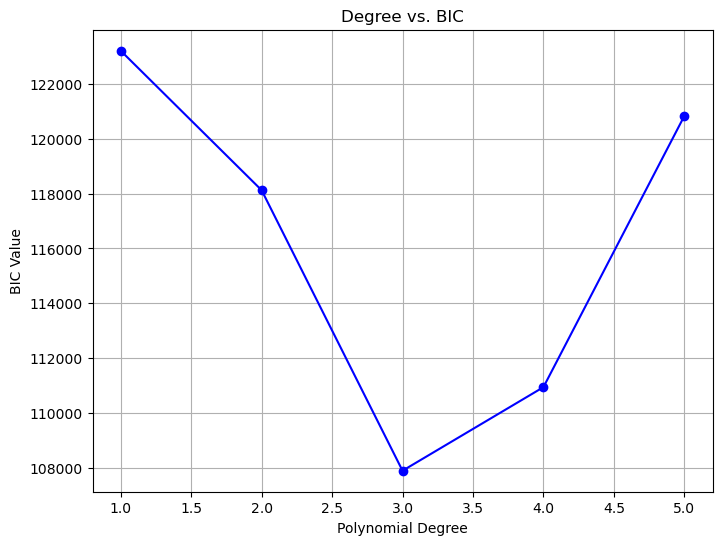

In [549]:
# Find the optimal degree of the polynomial
# -----------------------------------------

# Create a range of polynomial degrees to test
degrees = np.arange(1, 6)

# Initialize lists to store BIC values
bic_values = []

for degree in degrees:
    # Create Polynomial Features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(x_train)
    X_test_poly = poly.transform(x_test)

    # Initialize and train the polynomial regression model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Make predictions using the trained model on the test data
    y_pred = model.predict(X_test_poly)

    # Calculate the Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)

    # Count the number of parameters (features, interactions, and intercept)
    num_parameters = X_train_poly.shape[1]

    # Calculate the BIC
    n = len(y_test)  # Number of data points (sample size)
    bic = n * np.log(mse) + num_parameters * np.log(n)
    
    bic_values.append(bic)

# Plot the degree vs. BIC
plt.figure(figsize=(8, 6))
plt.plot(degrees, bic_values, marker='o', linestyle='-', color='b')
plt.title('Degree vs. BIC')
plt.xlabel('Polynomial Degree')
plt.ylabel('BIC Value')
plt.grid(True)
plt.show()

degree = 3 is prefered, since it yields the lowet value of BIC!
Now, we proceed to training the model.

##### J.2.3 Polynomial Regression training

In [550]:
# Train the model 
# -----------------------------------------------

degree = 3  # You can adjust the degree as needed
poly = PolynomialFeatures(degree=degree)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

poly_regression_model = LinearRegression()
poly_regression_model.fit(x_train_poly, y_train)

y_pred = poly_regression_model.predict(x_test_poly)

##### J.2.4 Polynomial Regression- validation scores
Compare with validation scores: MSE, RMSE, $R^2$ score

In [551]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

naive_prediction = np.full_like(y_test, np.mean(y_train))
naive_mse = mean_squared_error(y_test, naive_prediction)
naive_rmse = np.sqrt(naive_mse)
naive_r2 = r2_score(y_test, naive_prediction)
naive_std_dev = np.std(y_test)

print(f'Naive MSE: {naive_mse}')
print(f'Naive RMSE: {naive_rmse}')
print(f'Naive R2 Score: {naive_r2}')
print(f'Naive std deviation: {naive_std_dev}')
print();
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')

Naive MSE: 29285.806185401812
Naive RMSE: 171.1309620886934
Naive R2 Score: -1.6786753289421696e-05
Naive std deviation: 171.1295257401572

Mean Squared Error: 4809.7600846244595
Root Mean Squared Error: 69.3524338767174
R2 Score: 0.8357620481939145


The values are satisfactory. $R^2$ score of 0.83 indicates about 83% of the variation of the dependent vraiable can be explained by the independent model varaibles, showing a good fit of the model!

##### J.2.5 Further validation

##### J.2.5.1 Cross validation

In [552]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
scores = cross_val_score(poly_regression_model, x_train_poly, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_avg_mse = -np.mean(scores);
cv_avg_rmse = np.sqrt(cv_avg_mse)

print(f"CV avg_MSE: {cv_avg_mse}")
print(f"CV avg_RMSE: {cv_avg_rmse}")

CV avg_MSE: 4933.412537381557
CV avg_RMSE: 70.2382555120894


The CV RMSE also indicate good validation score!

##### J.2.5.2 Residual plots

Residual plots display the residual values (difference between observed values and predicted values) against the predicted values. The core ideas are:
1. Zero centricity:
    The residuals should be ideally randomly scattered around zero for the entire range of fitted values. This indicates that the residuals follow a normal distribution (as assumed) and that the degree of scattering is the same for all fitted values. The model’s predictions are correct on average rather than systematically too high or low.
2. Abscence of patterns:
    Structured patterns in the residual plot indicates modeling issues

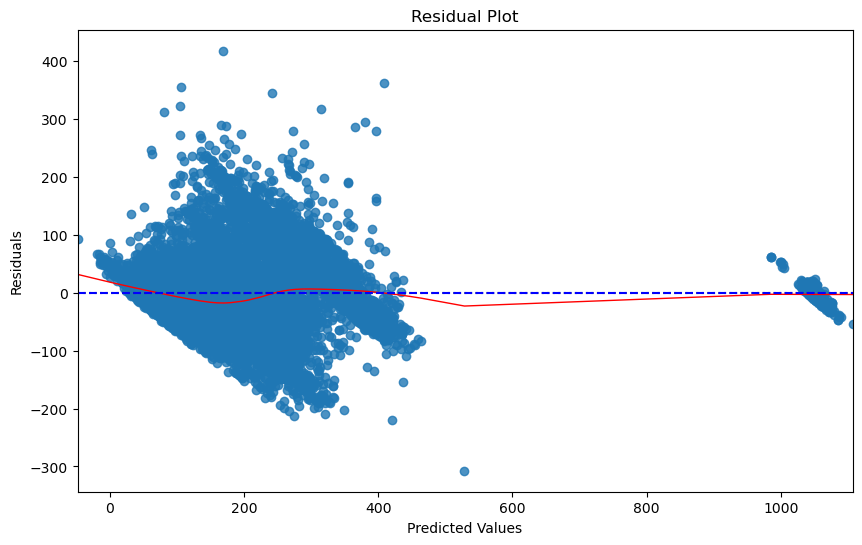

In [553]:
# Calculate residuals
residuals = y_test - y_pred

# Plotting the residuals
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='blue', linestyle='--')
plt.show()

The residual plots display a good trend in prediction!

The distribution of residual plots are checked again to confirm the assumption of normal distribution.

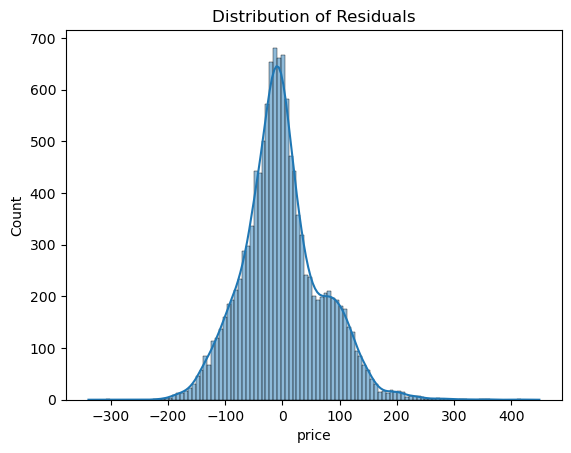

Mean of residuals: -0.28287484966063275
Standard deviation of residuals: 69.35185697905926


In [554]:
sns.histplot(
    residuals, kde=True, kde_kws=dict(cut=3)
)
plt.title('Distribution of Residuals')
plt.show()

# Calculate mean and standard deviation of residuals
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)

print(f"Mean of residuals: {mean_residuals}")
print(f"Standard deviation of residuals: {std_residuals}")

The distribution indicates that it is close to the assumed normal distribution, but not exactly a normal distribution. This is further explored through the QQplots as shown below. 

##### J.2.5.3 QQ Plots

QQ plots or quantile plots compares the quantiles of two distributions, in this case, the normal distribtuion on X-axis and thh distribution of residuals on the Y-axis. They are useful in assessing whether the dataset (residuals) follows a specific theoretical probability distribution (normal distribution, here). Ideally, all the points should lie on a straight diagonal line from the bottom-left to the top-right of the plot, indicating the model closely follows the assumed distribution.

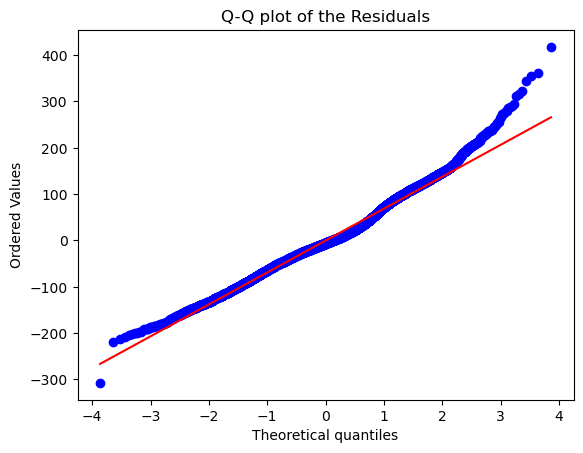

In [555]:
#QQ plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q plot of the Residuals')
plt.show()

It can be observed that the plot curves upwards (*right-skew/ positive skew*) slightly. 
This indicates that the number of larger observations are more than that is expected from a normal distribution. That is, the upper tail of the data’s distribution has been extended, relative to a normal distribution as evident from the residuals distribution plot.
This could be due to that the airfares dataset consists of skewed information. Since the data was scraped from a span of only 7 consecutive dates for a departure date set consisting of only 42 days and considers only local german airports, it is likey that the dataset has limited variablity in the lower-mid range of prices, with a few wide range of values on the upper side of prices.This can exhibit some positive skewness.

##### J.2.5.4 Scatter plot: Actual vs. predicted values

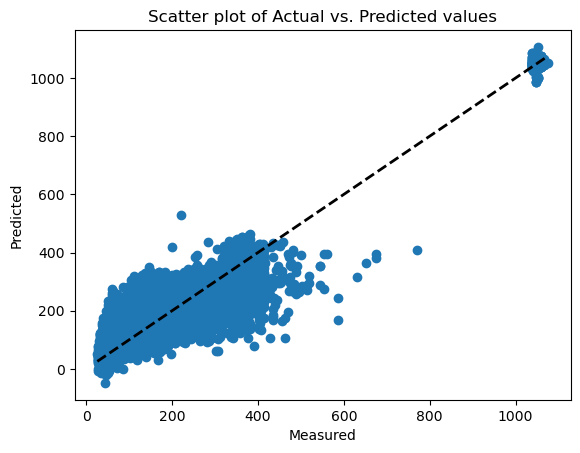

In [556]:
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Scatter plot of Actual vs. Predicted values')
plt.show()